# Feature Engineering

In [1]:
# Feature engineering:
    # Months as customer --> years as customer
    # Time difference between claim date and policy start date
    # Break policy csl into 2 features: injury claim per individual and injury claim per accident split by '/'
    # Maybe vehicle body type? If I'm predicting accident severity or claim amount...

In [2]:
import numpy as np
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('mako_r')
palette = sns.color_palette()

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Feature selection
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector

# Resampling
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE

# Model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Model evaulation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [4]:
df = pd.read_excel('../Data/Insurance Claims Data - Cleaned.xlsx')

In [5]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


## Data Preprocessing

In [6]:
# Drop irrelevant features
df = df.drop(['months_as_customer','age','policy_bind_date','policy_state','policy_csl',
              'policy_deductable','policy_annual_premium','umbrella_limit', 'insured_zip',
              'insured_sex','insured_education_level', 'insured_occupation', 'insured_hobbies',
              'insured_relationship','capital-gains', 'capital-loss','witnesses','fraud_reported'
             ],axis=1)

In [7]:
# Remove policy_number feature
df = df.drop('policy_number', axis=1)

In [8]:
# Normalize case of text columns to avoid inconsistencies
def lowercase_strings(x):
    if isinstance(x, str):
        return x.lower()
    else:
        return x

df = df.applymap(lowercase_strings)

In [9]:
# Replace NaN values with the string 'none'
df['authorities_contacted'] = df['authorities_contacted'].fillna('none')

In [10]:
# Replace '?' datapoints with 'unknown'
df = df.replace('?', 'unknown')

In [11]:
# Change the incident severity to a binary label
df['incident_severity'] = df['incident_severity'].apply(lambda x: 'major' if x in ['major damage','total loss'] else 'minor')

In [12]:
df.head()

,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year
0,2015-01-25,single vehicle collision,side collision,major,police,sc,columbus,9935 4th drive,5,1,yes,1,yes,71610,6510,13020,52080,saab,92x,2004
1,2015-01-21,vehicle theft,unknown,minor,police,va,riverwood,6608 mlk hwy,8,1,unknown,0,unknown,5070,780,780,3510,mercedes,e400,2007
2,2015-02-22,multi-vehicle collision,rear collision,minor,police,ny,columbus,7121 francis lane,7,3,no,2,no,34650,7700,3850,23100,dodge,ram,2007
3,2015-01-10,single vehicle collision,front collision,major,police,oh,arlington,6956 maple drive,5,1,unknown,1,no,63400,6340,6340,50720,chevrolet,tahoe,2014
4,2015-02-17,vehicle theft,unknown,minor,none,ny,arlington,3041 3rd ave,20,1,no,0,no,6500,1300,650,4550,accura,rsx,2009


## Feature Engineering

#### Datetime

In [13]:
def extract_time_features(df):
    
    '''
    Extracts year, month, week, day and weekday features from the 'incident_date' column.
    
    Parameters:
    -----------
    df: DataFrame
        A pandas DataFrame containing a column named 'incident_date'
    
    Returns:
    --------
    df: DataFrame
        A pandas DataFrame with new columns for 'incident_year','incident_month', 'incident_week',
        'incident_day' and 'incident_weekday' and the 'incident_date' column dropped.
    '''
    
    # Extract the relevant time features
    df['incident_year'] = df['incident_date'].dt.year
    df['incident_month'] = df['incident_date'].dt.month
    df['incident_week'] = df['incident_date'].dt.isocalendar().week
    df['incident_day'] = df['incident_date'].dt.day
    df['incident_weekday'] = df['incident_date'].dt.weekday
    
    # Drop the 'incident_date' feature
    df = df.drop('incident_date', axis=1)
    
    return df

df = extract_time_features(df)

#### Week period

In [14]:
# Improves LM, LinSVC

In [15]:
def week_period_indicator(df):
    
    '''
    Docstring
    '''
    
    if df['incident_weekday'] in (6,0,1):
        return 'start_week'
    elif df['incident_weekday'] in (2,3):
        return 'mid_week'
    else:
        return 'weekend'

df['week_period'] = df.apply(week_period_indicator, axis=1)

#### Time of day

In [16]:
# Worsens RF

In [17]:
def time_of_day_indicator(df):
    
    '''
    Docstring
    '''
    
    if df['incident_hour_of_the_day'] in (3,4,5,6,8,9):
        return 'morning'
    elif df['incident_hour_of_the_day'] in (10,11,12,13,14,15,16,17,18,19):
        return 'afternoon'
    else:
        return 'night'

#df['time_of_day'] = df.apply(time_of_day_indicator, axis=1)

#### Incident location

As seen during EDA, each incident occurred at a unique location. As such, this feature cannot improve the predictive power of the model. Rather than dropping the entire feature, however, we will convert this feature into the road type on which the incident occurred.

In [18]:
# Significantly worsens model but leaving it in causes too many features

In [19]:
df['incident_location'] = df['incident_location'].apply(lambda x: x.split()[-1])

#### Incident city

In [21]:
# Not all the same cities are in the same states

In [22]:
#df = df.drop('incident_city', axis=1)

#### Vehicle body shape

In [23]:
## Worsens RF

In [24]:
def auto_shape_indicator(df):
    
    '''
    Assigns an 'auto_shape' value to each row in the DataFrame based on the 'auto_model' value.
    
    Parameters:
    -----------
    df: DataFrame
        A pandas DataFrame containing a column named 'auto_model'.
    
    Returns:
    --------
    Series: A pandas Series containing the assigned 'auto_shape' value.
    '''
    
    if df['auto_model'] in ['ram','f150','silverado']:
        return 'pickup'
    elif df['auto_model'] in ['92x','95','93']:
        return 'wagon'
    elif df['auto_model'] in ['tahoe','pathfinder','highlander','mdx','forrestor','escape','wrangler',
                              'x5','crv','x6','malibu','fusion','ml350','grand cherokee']:
        return 'suv'
    else:
        return 'sedan'
    
#df['auto_shape'] = df.apply(auto_shape_indicator, axis=1)
#df = df.drop('auto_model',axis=1)

#### Vehicle age

In [25]:
## Worsens RF

In [26]:
#df['auto_age'] = df['incident_year'] - df['auto_year']

#### Variable encoding

In [27]:
# Label encoding
label_encoder = LabelEncoder()
df['incident_severity'] = label_encoder.fit_transform(df['incident_severity'])

LabelEncoder assigns labels to classes in alphabetical order. After transforming the label, the classes are as follows:
- `0`: major incident
- `1`: minor incident

In [28]:
# Dummy variable encoding
df_dummies = pd.get_dummies(df, drop_first=True, dtype=int)

In [29]:
df_dummies.head()

,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,incident_year,...,auto_model_rsx,auto_model_silverado,auto_model_tahoe,auto_model_tl,auto_model_ultima,auto_model_wrangler,auto_model_x5,auto_model_x6,week_period_start_week,week_period_weekend
0,0,5,1,1,71610,6510,13020,52080,2004,2015,...,0,0,0,0,0,0,0,0,1,0
1,1,8,1,0,5070,780,780,3510,2007,2015,...,0,0,0,0,0,0,0,0,0,0
2,1,7,3,2,34650,7700,3850,23100,2007,2015,...,0,0,0,0,0,0,0,0,1,0
3,0,5,1,1,63400,6340,6340,50720,2014,2015,...,0,0,1,0,0,0,0,0,0,1
4,1,20,1,0,6500,1300,650,4550,2009,2015,...,1,0,0,0,0,0,0,0,1,0


## Balancing Classes

In [30]:
X = df_dummies.drop('incident_severity', axis=1)
y = df_dummies['incident_severity']

In [31]:
# Standardise the data
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [32]:
# Balance the training data using SMOTE
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

## Feature Selection

#### Variance

In [ ]:
## Slightly worsens RF
# Only removes 4 out of 100 features, not significant

In [ ]:
# Normalise the data
mm_scaler = MinMaxScaler()
mm_scaler.fit(X)

X_norm = mm_scaler.transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)

In [ ]:
# Fit the variance threshold selector
var = VarianceThreshold(threshold=0.01)
var.fit(X_norm)

In [ ]:
low_var_feat = X_norm.columns[~var.get_support()]
low_var_feat

There are 4 features with a variance below 1% which will be dropped.

In [ ]:
# Drop the low variance features
X = X.drop(low_var_feat, axis=1)

#### Correlated features

In [ ]:
# Worsens RF
# Only removes 5 out of 100 features, not significant

In [ ]:
corr = SmartCorrelatedSelection(selection_method='model_performance',
                                estimator=LogisticRegression(),
                                scoring='roc_auc')

corr.fit(X_scaled, y)

In [ ]:
corr.correlated_feature_sets_

In [ ]:
corr.features_to_drop_

Based on this we will be keeping:
- Vehicle claim
- Incident month

In [ ]:
X_scaled = X_scaled.drop(corr.features_to_drop_, axis=1)

In [ ]:
X_scaled.shape

In [ ]:
## However, doing both variance and correlated feature selection together barely worsened the model
# Does remove 9 features so maybe worth keeping...

#### Mutual Information

## Splitting the Data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## Model Building

We will first evaluate the performance of a number of base machine learning models using the default hyperparameters and compare the results. The initial performance will be based on the model accuracy to identify the models most suited to the dataset. The following models will be assessed:
- **Logistic regression**
- **Decision tree classifier**
- **Support vector machine**
- **Linear support vector machine**
- **K-Nearest neighbours**
- **Random forest classifier**
- **Extreme gradient boosted decision tree**

In [34]:
# Create a dictionary of model names and the associated classifier
models = {'lm':LogisticRegression(),
          'dt':DecisionTreeClassifier(),
          'svc':SVC(),
          'linsvc':LinearSVC(),
          'knn':KNeighborsClassifier(),
          'rf':RandomForestClassifier(),
          'xgb':XGBClassifier()}

# Create an empty list to store the accuracy scores
accuracies = []

# Iterate through each model in the models dictionary
for model, classifier in models.items():
    
    # Fit the model to the training data
    classifier.fit(X_train, y_train)
    
    # Make predictions from the validation set
    y_pred = classifier.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the model name and accuracy score to the accuracies list
    accuracies.append([model, accuracy])

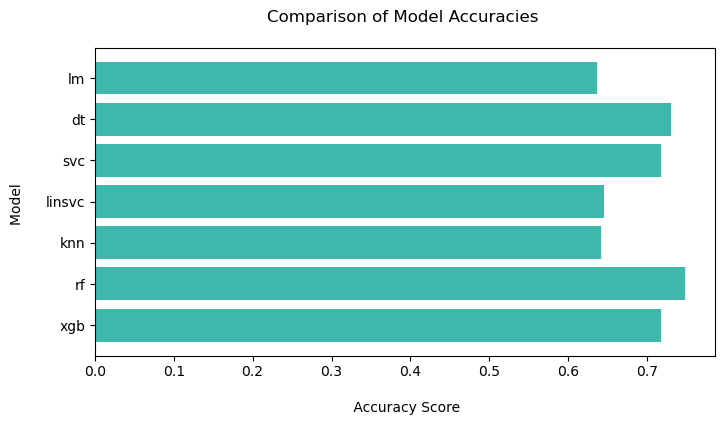

In [35]:
# Plot and compare the model accuracies
model_names = [item[0] for item in accuracies]
accuracy_scores = [item[1] for item in accuracies]

plt.figure(figsize=(8,4))
plt.barh(model_names, accuracy_scores, color=palette[1])
plt.title('Comparison of Model Accuracies \n')
plt.ylabel('Model \n')
plt.xlabel('\n Accuracy Score')
plt.gca().invert_yaxis()
plt.show()

Top performing models based on accuracy alone are:
- Logistic Regression
- Linear Support Vector Machine

We'll take a more detailed look at the performance of these three models by looking at the classification reports and confusion matrices, as well as running a grid search for the optimal hyperparameters.

In [36]:
def evaluate_model(actual, predicted):
    
    '''
    Docstring
    '''
    
    print('Classification Report \n')
    print(classification_report(actual, predicted))
    print('\n')
    print('Confusion Matrix')
    
    cm = confusion_matrix(actual, predicted)
    disp = ConfusionMatrixDisplay(cm, display_labels=['major','minor'])
    disp.plot(cmap='Blues')

### Logistic Regression

Classification Report 

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       106
           1       0.97      0.74      0.84       117

    accuracy                           0.85       223
   macro avg       0.87      0.86      0.85       223
weighted avg       0.88      0.85      0.85       223



Confusion Matrix


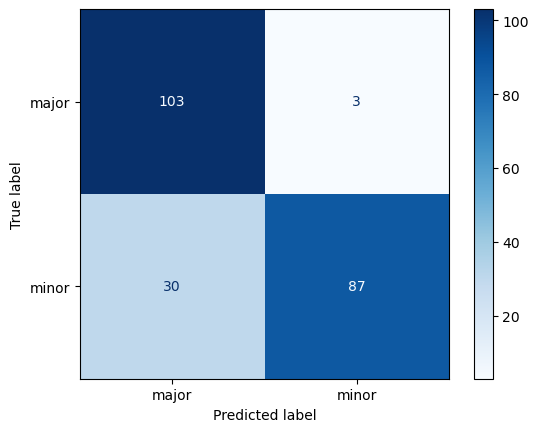

In [37]:
# Instantiate the base model
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train, y_train)

# Generate predictions
y_pred_logreg = logreg.predict(X_test)

# Evaluate the model performance
evaluate_model(y_test, y_pred_logreg)

In [ ]:
# Create the parameter grid
logreg_params = {'C':[0.00,0.1,0.11]}

# Instantiate the grid search
logreg_grid = GridSearchCV(estimator=logreg,
                           param_grid=logreg_params,
                           scoring='accuracy',
                           cv=5)

# Fit the model to the training data
logreg_grid.fit(X_train, y_train)

In [ ]:
logreg_grid.best_params_

In [ ]:
# Generate predictions
y_pred_logreg_grid = logreg_grid.predict(X_test)

# Evaluate the model performance
evaluate_model(y_test, y_pred_logreg_grid)

### Random Forest

Classification Report 

              precision    recall  f1-score   support

           0       0.66      0.95      0.78       106
           1       0.93      0.56      0.70       117

    accuracy                           0.74       223
   macro avg       0.79      0.75      0.74       223
weighted avg       0.80      0.74      0.74       223



Confusion Matrix


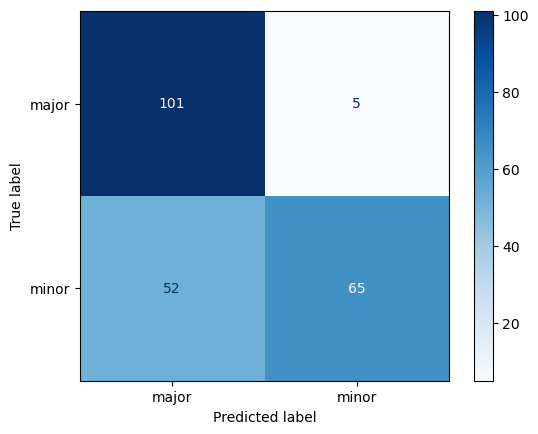

In [37]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

evaluate_model(y_test, y_pred_rf)

In [43]:
pd.DataFrame(columns=['feature_importance'],index=X.columns, data=rf.feature_importances_).sort_values(by='feature_importance', ascending=False)

,feature_importance
vehicle_claim,0.089375
property_claim,0.084019
total_claim_amount,0.075147
injury_claim,0.068211
collision_type_unknown,0.061154
...,...
auto_model_silverado,0.001065
auto_model_rsx,0.000930
authorities_contacted_unknown,0.000177
incident_state_unknown,0.000029


### XGBoost

Classification Report 

              precision    recall  f1-score   support

           0       0.66      0.84      0.74       106
           1       0.81      0.61      0.69       117

    accuracy                           0.72       223
   macro avg       0.73      0.72      0.72       223
weighted avg       0.74      0.72      0.71       223



Confusion Matrix


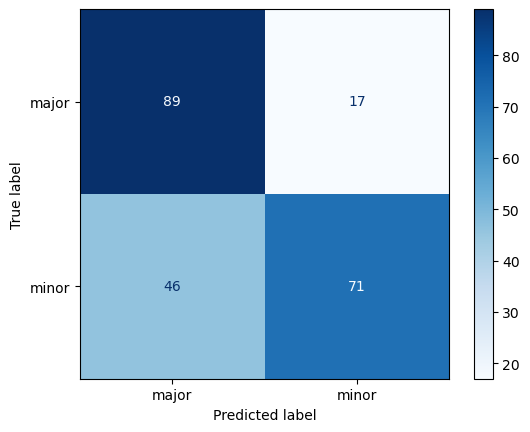

In [38]:
# Instantiate the base model
xgb = XGBClassifier(random_state=42)

# Fit the model to the training data
xgb.fit(X_train, y_train)

# Generate predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate the model performance
evaluate_model(y_test, y_pred_xgb)

### Linear SVC

Classification Report 

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       106
           1       0.90      0.79      0.85       117

    accuracy                           0.85       223
   macro avg       0.85      0.85      0.85       223
weighted avg       0.85      0.85      0.85       223



Confusion Matrix


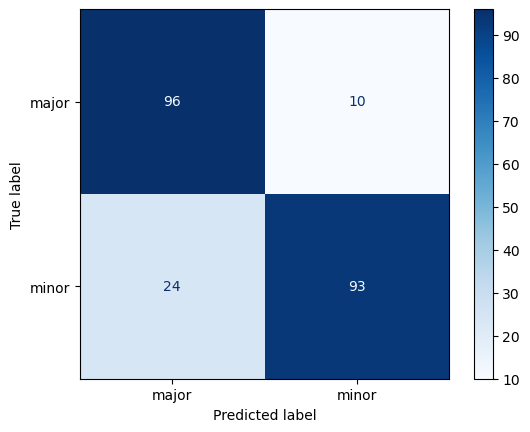

In [39]:
# Instantiate the base model
linsvc = LinearSVC()

# Fit the model to the training data
linsvc.fit(X_train, y_train)

# Generate predictions
y_pred_linsvc = linsvc.predict(X_test)

# Evaluate the model performance
evaluate_model(y_test, y_pred_linsvc)

In [ ]:
# Create the parameter grid
linsvc_params = {'penalty':['l1','l2'],
                 'C':[0.1,0.5,1.0]}

# Instantiate the grid search
linsvc_grid = GridSearchCV(estimator=linsvc,
                           param_grid=linsvc_params,
                           scoring='accuracy',
                           cv=5)

# Fit the model to the training data
linsvc_grid.fit(X_train, y_train)

In [ ]:
linsvc_grid.best_params_

In [ ]:
# Generate predictions
y_pred_linsvc_grid = linsvc_grid.predict(X_test)

# Evaluate the model performance
evaluate_model(y_test, y_pred_linsvc_grid)

### Neural Network

In [45]:
nn = MLPClassifier(max_iter=500, random_state=42)

nn.fit(X_train_scaled, y_train)

MLPClassifier(max_iter=500, random_state=42)

Classification Report 

              precision    recall  f1-score   support

           0       0.61      0.76      0.68       105
           1       0.64      0.46      0.54        95

    accuracy                           0.62       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.62      0.62      0.61       200



Confusion Matrix


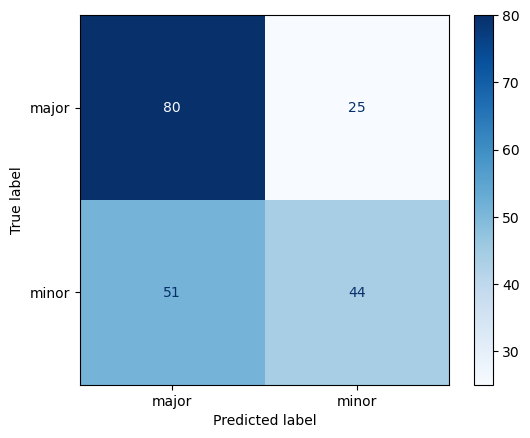

In [46]:
y_pred_nn = nn.predict(X_test_scaled)

evaluate_model(y_test, y_pred_nn)